# Práctica DL

1. **Carga de librerías y datos**

2. **División train y test, análisis exploratorio y preprocesado de datos**

3. **Modelos**

 <ul>
   3.1 Modelo 1D - MLP para regresión

   3.2 Modelo 2D - CNN VGG16 con Fine-Tuning para regresión

   3.3 Modelo combinado con Late Fusion de modelo 1D - MLP y 2D - CNN VGG16 con Fine-Tuning para regresión

   3.4 Modelo combinado con Early Fusion de modelo 1D - MLP y embeddings de modelo 2D - CNN VGG16 con Fine-Tuning para regresión
  </ul>


4. **Optimización de hiper-parámetros**

5. **Conclusiones**

# 1. Carga de librerías y datos

In [28]:
import sys
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D, Concatenate, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.constraints import max_norm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.fmin import space_eval

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils

from sklearn.metrics import confusion_matrix, r2_score

import seaborn as sn

In [2]:
pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=e44d0e11fc6a2d8f30f517d8a461699901a0d3c9f0735023162b5be0a557d7c5
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/keepcoding_DL/data_KC.csv", sep=';')
images = np.load("/content/drive/MyDrive/keepcoding_DL/images_KC.npy")
data.shape, images.shape

((2138, 30), (2138, 224, 224, 3))

In [4]:
muestra_i = 2
print(data.iloc[muestra_i])

id                                                                 13418779
log_price                                                          6.620073
property_type                                                         House
room_type                                                   Entire home/apt
amenities                 {TV,"Cable TV",Internet,"Wireless Internet",Ki...
accommodates                                                              4
bathrooms                                                               1.0
bed_type                                                           Real Bed
cancellation_policy                                                flexible
cleaning_fee                                                           True
city                                                                     SF
description               This light-filled home-away-from-home is super...
first_review                                                            NaN
host_has_pro

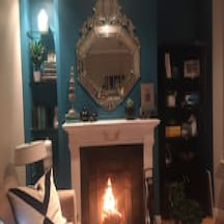

[[[0.5176471  0.45490196 0.35686275]
  [0.5294118  0.46666667 0.36862746]
  [0.54509807 0.47843137 0.38039216]
  ...
  [0.3372549  0.24705882 0.2       ]
  [0.32941177 0.24313726 0.19215687]
  [0.3254902  0.23921569 0.1882353 ]]

 [[0.5176471  0.45490196 0.35686275]
  [0.5294118  0.46666667 0.36862746]
  [0.54509807 0.47843137 0.38431373]
  ...
  [0.34117648 0.24705882 0.2       ]
  [0.32941177 0.24313726 0.19215687]
  [0.3254902  0.23921569 0.1882353 ]]

 [[0.5176471  0.45490196 0.35686275]
  [0.5294118  0.46666667 0.36862746]
  [0.54509807 0.48235294 0.38431373]
  ...
  [0.34117648 0.24705882 0.2       ]
  [0.33333334 0.24705882 0.19607843]
  [0.32941177 0.24313726 0.19215687]]

 ...

 [[0.5372549  0.5294118  0.5058824 ]
  [0.5176471  0.5019608  0.4745098 ]
  [0.45882353 0.42352942 0.4       ]
  ...
  [0.34117648 0.19215687 0.12941177]
  [0.34117648 0.19607843 0.13333334]
  [0.34117648 0.19607843 0.13333334]]

 [[0.5686275  0.57254905 0.5529412 ]
  [0.6156863  0.6117647  0.58431375]


In [5]:
R = images[muestra_i,:,:,0]
G = images[muestra_i,:,:,1]
B = images[muestra_i,:,:,2]
rgb_muestra = np.stack([B, G, R], axis=2)
cv2_imshow(rgb_muestra*255)
print(images[muestra_i])

In [6]:
seed = 42
np.random.seed(seed = 42)
keras.utils.set_random_seed(seed = 42)
tf.config.experimental.enable_op_determinism()

# 2. División train y test, análisis exploratorio y preprocesado de datos tabulares

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, val = train_test_split(train, test_size=0.1, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de validation: {val.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

train.head(5).T

Dimensiones del dataset de training: (1539, 30)
Dimensiones del dataset de validation: (171, 30)
Dimensiones del dataset de test: (428, 30)


,387,163,1075,1889,1180
id,212297,15806332,11768316,17008563,4395112
log_price,3.332205,4.828314,4.094345,5.236442,3.89182
property_type,Apartment,Apartment,House,Apartment,Apartment
room_type,Shared room,Shared room,Private room,Entire home/apt,Private room
amenities,"{""translation missing: en.hosting_amenity_49""}","{TV,Internet,""Wireless Internet"",""Air conditio...","{TV,Kitchen,""Smoke detector"",""Carbon monoxide ...","{Internet,""Wireless Internet"",""Air conditionin...","{""Wireless Internet"",Essentials,Shampoo}"
accommodates,1,2,2,4,2
bathrooms,1.0,1.0,1.0,1.0,1.0
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,flexible,strict,flexible,strict,flexible
cleaning_fee,False,False,False,True,True


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1539 entries, 387 to 1057
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1539 non-null   int64  
 1   log_price               1539 non-null   float64
 2   property_type           1539 non-null   object 
 3   room_type               1539 non-null   object 
 4   amenities               1539 non-null   object 
 5   accommodates            1539 non-null   int64  
 6   bathrooms               1534 non-null   float64
 7   bed_type                1539 non-null   object 
 8   cancellation_policy     1539 non-null   object 
 9   cleaning_fee            1539 non-null   bool   
 10  city                    1539 non-null   object 
 11  description             1539 non-null   object 
 12  first_review            1162 non-null   object 
 13  host_has_profile_pic    1529 non-null   object 
 14  host_identity_verified  1529 non-null   obj

Tras un primer análisis exploratorio decidimos eliminar las siguientes columnas por tener poca información o información que consideramos que no tiene valor para este experimento. En el caso del Price lo quitamos para usar la columna log_price:

'thumbnail_url', 'name','id','amenities','description','first_review','neighbourhood','host_response_rate','host_since','last_review','review_scores_rating','Price'

Imputamos valores nulos en algunas columnas con la moda de esa columna y con false para las variables booleanas. Finalmente eliminamos todas las filas que contengan algún nulo

Transformamos todas las variables a float y codificamos las variables categóricas con la media de la columna log_price

Generámos algunas características y eliminamos las columnas originales

In [8]:
train_clean = train.drop(['thumbnail_url', 'name','id','amenities','description','first_review','neighbourhood','host_response_rate','host_since','last_review','review_scores_rating','Price'], axis=1)
train_clean['bathrooms'].fillna(train_clean['bathrooms'].mode()[0], inplace=True)
train_clean['bedrooms'].fillna(train_clean['bedrooms'].mode()[0], inplace=True)
train_clean['beds'].fillna(train_clean['beds'].mode()[0], inplace=True)
train_clean['host_has_profile_pic'].fillna('f', inplace=True)
train_clean['host_identity_verified'].fillna('f', inplace=True)

train_clean = train_clean.dropna()

train_clean["Zipcode_encoded"] = train_clean.groupby("zipcode")["log_price"].transform("mean")
train_clean["Property_Type_encoded"] = train_clean.groupby("property_type")["log_price"].transform("mean")
train_clean["Bed_Type_encoded"] = train_clean.groupby("bed_type")["log_price"].transform("mean")
train_clean["Room_Type_encoded"] = train_clean.groupby("room_type")["log_price"].transform("mean")
train_clean["Cancellation_Policy_encoded"] = train_clean.groupby("cancellation_policy")["log_price"].transform("mean")
train_clean["city_Policy_encoded"] = train_clean.groupby("city")["log_price"].transform("mean")

train_clean["cleaning_fee"] = train_clean["cleaning_fee"].astype(np.float64)
train_clean.loc[train_clean["host_has_profile_pic"] == 't', "host_has_profile_pic"] = True
train_clean.loc[train_clean["host_has_profile_pic"] == 'f', "host_has_profile_pic"] = False
train_clean["host_has_profile_pic"] = train_clean["host_has_profile_pic"].astype(np.float64)
train_clean.loc[train_clean["host_identity_verified"] == 't', "host_identity_verified"] = True
train_clean.loc[train_clean["host_identity_verified"] == 'f', "host_identity_verified"] = False
train_clean["host_identity_verified"] = train_clean["host_identity_verified"].astype(np.float64)
train_clean.loc[train_clean["instant_bookable"] == 't', "instant_bookable"] = True
train_clean.loc[train_clean["instant_bookable"] == 'f', "instant_bookable"] = False
train_clean["instant_bookable"] = train_clean["instant_bookable"].astype(np.float64)
train_clean["accommodates"] = train_clean["accommodates"].astype(np.float64)
train_clean["number_of_reviews"] = train_clean["number_of_reviews"].astype(np.float64)

# Generamos características
train_clean['bed_bath_rooms']   = train_clean['bedrooms']*train_clean['bathrooms']
train_clean['Latitude_square']   = train_clean['latitude'].apply(lambda x: x**2)
train_clean['Longitude_square']   = train_clean['longitude'].apply(lambda x: x**2)

train_clean = train_clean.drop(['zipcode','property_type','bed_type','room_type','cancellation_policy','city','bedrooms','bathrooms','latitude','longitude'], axis=1)

train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1523 entries, 387 to 1057
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   log_price                    1523 non-null   float64
 1   accommodates                 1523 non-null   float64
 2   cleaning_fee                 1523 non-null   float64
 3   host_has_profile_pic         1523 non-null   float64
 4   host_identity_verified       1523 non-null   float64
 5   instant_bookable             1523 non-null   float64
 6   number_of_reviews            1523 non-null   float64
 7   beds                         1523 non-null   float64
 8   Zipcode_encoded              1523 non-null   float64
 9   Property_Type_encoded        1523 non-null   float64
 10  Bed_Type_encoded             1523 non-null   float64
 11  Room_Type_encoded            1523 non-null   float64
 12  Cancellation_Policy_encoded  1523 non-null   float64
 13  city_Policy_encoded  

<ipython-input-8-8c55dae5680d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean["Zipcode_encoded"] = train_clean.groupby("zipcode")["log_price"].transform("mean")
<ipython-input-8-8c55dae5680d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean["Property_Type_encoded"] = train_clean.groupby("property_type")["log_price"].transform("mean")
<ipython-input-8-8c55dae5680d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [11]:
from ydata_profiling import ProfileReport
ProfileReport(train_clean)

Output hidden; open in https://colab.research.google.com to view.

Aplicamos los mismos criterios de proprocesado de Train a Val y Test

In [9]:
val_clean = val.drop(['thumbnail_url', 'name','id','amenities','description','first_review','neighbourhood','host_response_rate','host_since','last_review','review_scores_rating','Price'], axis=1)
val_clean['bathrooms'].fillna(val_clean['bathrooms'].mode()[0], inplace=True)
val_clean['bedrooms'].fillna(val_clean['bedrooms'].mode()[0], inplace=True)
val_clean['beds'].fillna(val_clean['beds'].mode()[0], inplace=True)
val_clean['host_has_profile_pic'].fillna('f', inplace=True)
val_clean['host_identity_verified'].fillna('f', inplace=True)

val_clean = val_clean.dropna()

val_clean["Zipcode_encoded"] = val_clean.groupby("zipcode")["log_price"].transform("mean")
val_clean["Property_Type_encoded"] = val_clean.groupby("property_type")["log_price"].transform("mean")
val_clean["Bed_Type_encoded"] = val_clean.groupby("bed_type")["log_price"].transform("mean")
val_clean["Room_Type_encoded"] = val_clean.groupby("room_type")["log_price"].transform("mean")
val_clean["Cancellation_Policy_encoded"] = val_clean.groupby("cancellation_policy")["log_price"].transform("mean")
val_clean["city_Policy_encoded"] = val_clean.groupby("city")["log_price"].transform("mean")

val_clean["cleaning_fee"] = val_clean["cleaning_fee"].astype(np.float64)
val_clean.loc[val_clean["host_has_profile_pic"] == 't', "host_has_profile_pic"] = True
val_clean.loc[val_clean["host_has_profile_pic"] == 'f', "host_has_profile_pic"] = False
val_clean["host_has_profile_pic"] = val_clean["host_has_profile_pic"].astype(np.float64)
val_clean.loc[val_clean["host_identity_verified"] == 't', "host_identity_verified"] = True
val_clean.loc[val_clean["host_identity_verified"] == 'f', "host_identity_verified"] = False
val_clean["host_identity_verified"] = val_clean["host_identity_verified"].astype(np.float64)
val_clean.loc[val_clean["instant_bookable"] == 't', "instant_bookable"] = True
val_clean.loc[val_clean["instant_bookable"] == 'f', "instant_bookable"] = False
val_clean["instant_bookable"] = val_clean["instant_bookable"].astype(np.float64)
val_clean["accommodates"] = val_clean["accommodates"].astype(np.float64)
val_clean["number_of_reviews"] = val_clean["number_of_reviews"].astype(np.float64)

# Generamos características
val_clean['bed_bath_rooms']   = val_clean['bedrooms']*val_clean['bathrooms']
val_clean['Latitude_square']   = val_clean['latitude'].apply(lambda x: x**2)
val_clean['Longitude_square']   = val_clean['longitude'].apply(lambda x: x**2)

val_clean = val_clean.drop(['zipcode','property_type','bed_type','room_type','cancellation_policy','city','bedrooms','bathrooms','latitude','longitude'], axis=1)
val_clean.shape

(169, 17)

In [10]:
test_clean = test.drop(['thumbnail_url', 'name','id','amenities','description','first_review','neighbourhood','host_response_rate','host_since','last_review','review_scores_rating','Price'], axis=1)
test_clean['bathrooms'].fillna(test_clean['bathrooms'].mode()[0], inplace=True)
test_clean['bedrooms'].fillna(test_clean['bedrooms'].mode()[0], inplace=True)
test_clean['beds'].fillna(test_clean['beds'].mode()[0], inplace=True)
test_clean['host_has_profile_pic'].fillna('f', inplace=True)
test_clean['host_identity_verified'].fillna('f', inplace=True)

test_clean = test_clean.dropna()

test_clean["Zipcode_encoded"] = test_clean.groupby("zipcode")["log_price"].transform("mean")
test_clean["Property_Type_encoded"] = test_clean.groupby("property_type")["log_price"].transform("mean")
test_clean["Bed_Type_encoded"] = test_clean.groupby("bed_type")["log_price"].transform("mean")
test_clean["Room_Type_encoded"] = test_clean.groupby("room_type")["log_price"].transform("mean")
test_clean["Cancellation_Policy_encoded"] = test_clean.groupby("cancellation_policy")["log_price"].transform("mean")
test_clean["city_Policy_encoded"] = test_clean.groupby("city")["log_price"].transform("mean")

test_clean["cleaning_fee"] = test_clean["cleaning_fee"].astype(np.float64)
test_clean.loc[test_clean["host_has_profile_pic"] == 't', "host_has_profile_pic"] = True
test_clean.loc[test_clean["host_has_profile_pic"] == 'f', "host_has_profile_pic"] = False
test_clean["host_has_profile_pic"] = test_clean["host_has_profile_pic"].astype(np.float64)
test_clean.loc[test_clean["host_identity_verified"] == 't', "host_identity_verified"] = True
test_clean.loc[test_clean["host_identity_verified"] == 'f', "host_identity_verified"] = False
test_clean["host_identity_verified"] = test_clean["host_identity_verified"].astype(np.float64)
test_clean.loc[test_clean["instant_bookable"] == 't', "instant_bookable"] = True
test_clean.loc[test_clean["instant_bookable"] == 'f', "instant_bookable"] = False
test_clean["instant_bookable"] = test_clean["instant_bookable"].astype(np.float64)
test_clean["accommodates"] = test_clean["accommodates"].astype(np.float64)
test_clean["number_of_reviews"] = test_clean["number_of_reviews"].astype(np.float64)

# Generamos características
test_clean['bed_bath_rooms']   = test_clean['bedrooms']*test_clean['bathrooms']
test_clean['Latitude_square']   = test_clean['latitude'].apply(lambda x: x**2)
test_clean['Longitude_square']   = test_clean['longitude'].apply(lambda x: x**2)

test_clean = test_clean.drop(['zipcode','property_type','bed_type','room_type','cancellation_policy','city','bedrooms','bathrooms','latitude','longitude'], axis=1)
test_clean.shape

(422, 17)

In [11]:
# Dataset de train
data_train = train_clean.values
y_train = data_train[:,0]
X_train = data_train[:,1:]

# # Dataset de validation
data_val = val_clean.values
y_val = data_val[:,0]
X_val = data_val[:,1:]

# # Dataset de test
data_test = test_clean.values
y_test = data_test[:,0]
X_test = data_test[:,1:]

Normalizamos con MinMaxScaler

In [12]:
Xscaler = MinMaxScaler().fit(X_train)

XtrainScaled = Xscaler.transform(X_train)
XvalScaled = Xscaler.transform(X_val)
XtestScaled = Xscaler.transform(X_test)

Yscaler = MinMaxScaler().fit(y_train.reshape(-1, 1))

YtrainScaled = Yscaler.transform(y_train.reshape(-1, 1)).reshape(-1, 1)
YvalScaled = Yscaler.transform(y_val.reshape(-1, 1)).reshape(-1, 1)
YtestScaled = Yscaler.transform(y_test.reshape(-1, 1)).reshape(-1, 1)

YtrainScaled

array([[0.09989778],
       [0.43816602],
       [0.2722166 ],
       ...,
       [0.49398074],
       [0.3638917 ],
       [0.53870887]])

# 3. Modelos

## 3.1. Modelo 1D - MLP para regresión

Configuramos un modelo 1D - MLP sencillo para realizar una primera prueba de configuración para la rama 1D. Escogemos un modelo de 3 capas con activación linear en la última capa ya que es un problema de regresión

In [40]:
model1D = Sequential()
model1D.add(Dense(124, input_shape=(XtrainScaled.shape[-1],), activation="relu"))
model1D.add(Dense(32, activation="relu"))
model1D.add(Dense(1, activation="linear"))
model1D.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 124)               2108      
                                                                 
 dense_18 (Dense)            (None, 32)                4000      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6141 (23.99 KB)
Trainable params: 6141 (23.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
n_epochs = 100
batch_size = 256
lr = 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=lr,
      decay_steps=100,
      decay_rate=0.5,
      staircase=True)

model1D.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=lr_schedule), metrics=["mse", "mae","R2Score"])
H = model1D.fit(XtrainScaled, YtrainScaled, validation_data=(XvalScaled, YvalScaled), epochs=n_epochs, batch_size=batch_size)

predictions1D_train = model1D.predict(XtrainScaled, batch_size=batch_size)
predictions1D_val = model1D.predict(XvalScaled, batch_size=batch_size)
predictions1D_test = model1D.predict(XtestScaled, batch_size=batch_size)
#print(predictions1D_test)
eval_test = model1D.evaluate(XtestScaled, YtestScaled)
print(eval_test)

Epoch 1/100
6/6 [==============================] - 1s 67ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1596 - r2_score: -0.9159 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.1028 - val_r2_score: 0.3613
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0980 - r2_score: 0.3001 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0958 - val_r2_score: 0.4371
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0927 - r2_score: 0.3609 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0977 - val_r2_score: 0.4346
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0892 - r2_score: 0.4122 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0909 - val_r2_score: 0.4943
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0867 - r2_score: 0.4403 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0885 - va

[]

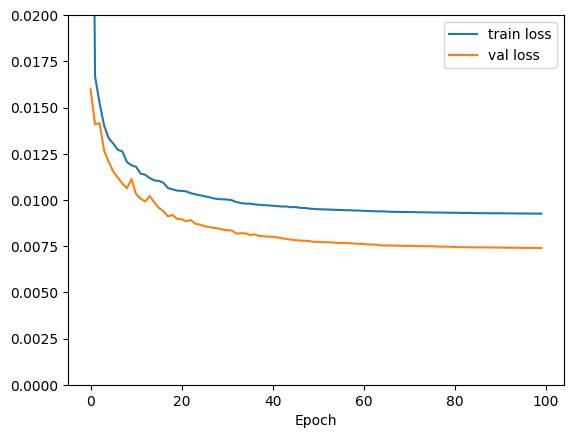

In [26]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
# plt.plot(H.history['r2_score'], label='train r2')
# plt.plot(H.history['val_r2_score'], label='val r2')
plt.legend()
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim([0, 0.02])
plt.plot()

In [27]:
pred = Yscaler.inverse_transform(predictions1D_test)
np.exp(pred)

array([[ 183.61409 ],
       [ 149.99272 ],
       [ 216.05646 ],
       [  64.56646 ],
       [ 345.33942 ],
       [ 143.37234 ],
       [  55.240627],
       [ 156.0123  ],
       [ 168.27826 ],
       [ 134.91127 ],
       [  82.40027 ],
       [  64.56415 ],
       [  98.91139 ],
       [ 156.61702 ],
       [ 173.40015 ],
       [  58.702713],
       [  59.46289 ],
       [ 224.48123 ],
       [  71.28487 ],
       [  92.65792 ],
       [ 101.83952 ],
       [  64.267586],
       [ 116.43617 ],
       [ 363.23914 ],
       [  67.40804 ],
       [  65.505066],
       [ 147.9893  ],
       [  57.163395],
       [  57.277412],
       [  67.22864 ],
       [ 158.39345 ],
       [  64.68859 ],
       [  96.56065 ],
       [ 258.96158 ],
       [  75.9771  ],
       [ 180.85599 ],
       [ 168.84073 ],
       [  81.938515],
       [ 132.5334  ],
       [  43.773125],
       [  79.51184 ],
       [  82.77324 ],
       [ 143.12877 ],
       [ 224.26535 ],
       [ 109.88802 ],
       [  

In [28]:
np.exp(pred) - np.exp(y_test)

array([[ -63.38591003,   58.61408997,  -66.38591003, ...,   63.61408997,
         143.61408997,   93.61408997],
       [ -97.00727844,   24.99272156, -100.00727844, ...,   29.99272156,
         109.99272156,   59.99272156],
       [ -30.94354248,   91.05645752,  -33.94354248, ...,   96.05645752,
         176.05645752,  126.05645752],
       ...,
       [-105.71232605,   16.28767395, -108.71232605, ...,   21.28767395,
         101.28767395,   51.28767395],
       [-181.55406189,  -59.55406189, -184.55406189, ...,  -54.55406189,
          25.44593811,  -24.55406189],
       [-156.3785553 ,  -34.3785553 , -159.3785553 , ...,  -29.3785553 ,
          50.6214447 ,    0.6214447 ]])

## 3.2. Modelo 2D - CNN VGG16 con Fine-Tuning para regresión

Configuramos un modelo 2D - CNN basado en la red pre entrenada VGG16. Utilizamos la técnica de Fine-Tuning eliminando las últimas capas y añadiendo unas capas densas para regresión.

Para el preprocesado de imágenes utilizamos el mismo que la red preentrenada con el mode = torch que devuelve primero escala los valores entre 0 y 1 y luego aplica la normalización en cada canal

In [13]:
images = images*255
images

array([[[[174., 147., 104.],
         [172., 145., 102.],
         [172., 140.,  99.],
         ...,
         [144., 125.,  93.],
         [144., 125.,  93.],
         [144., 125.,  93.]],

        [[174., 147., 104.],
         [172., 145., 102.],
         [172., 141., 100.],
         ...,
         [144., 125.,  93.],
         [144., 125.,  93.],
         [144., 125.,  93.]],

        [[174., 147., 104.],
         [172., 145., 102.],
         [173., 141., 100.],
         ...,
         [144., 125.,  93.],
         [144., 125.,  93.],
         [144., 125.,  93.]],

        ...,

        [[114.,  94.,  67.],
         [111.,  91.,  64.],
         [112.,  92.,  65.],
         ...,
         [ 74.,  50.,  37.],
         [ 79.,  49.,  39.],
         [ 79.,  47.,  38.]],

        [[113.,  93.,  66.],
         [111.,  91.,  64.],
         [111.,  91.,  64.],
         ...,
         [ 75.,  52.,  38.],
         [ 80.,  50.,  40.],
         [ 81.,  48.,  39.]],

        [[113.,  93.,  66.],
       

In [14]:
preprocess = imagenet_utils.preprocess_input
images = preprocess(images,mode="torch")
images[0]

array([[[ 0.86180323,  0.5378152 ,  0.0081918 ],
        [ 0.82755375,  0.50280124, -0.02666659],
        [ 0.82755375,  0.41526622, -0.07895417],
        ...,
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933]],

       [[ 0.86180323,  0.5378152 ,  0.0081918 ],
        [ 0.82755375,  0.50280124, -0.02666659],
        [ 0.82755375,  0.4327732 , -0.06152498],
        ...,
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933]],

       [[ 0.86180323,  0.5378152 ,  0.0081918 ],
        [ 0.82755375,  0.50280124, -0.02666659],
        [ 0.8446785 ,  0.4327732 , -0.06152498],
        ...,
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933],
        [ 0.34806067,  0.15266106, -0.18352933]],

       ...,

       [[-0.16568205, -0.39005598, -0.63668835],
        [-0

In [15]:
idx_train = train_clean.index.values
idx_val = val_clean.index.values
idx_test = test_clean.index.values

In [16]:
train_x_imgs = images[idx_train, :,:,:]
val_x_imgs = images[idx_val, :,:,:]
test_x_imgs = images[idx_test, :,:,:]
# Imágenes:
(train_x_imgs.shape, val_x_imgs.shape, test_x_imgs.shape)

((1523, 224, 224, 3), (169, 224, 224, 3), (422, 224, 224, 3))

In [17]:
# Datos tabulares:
(train_clean.shape, val_clean.shape, test_clean.shape)

((1523, 17), (169, 17), (422, 17))

In [39]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')

last = base_model.layers[-1].output
x = GlobalMaxPooling2D()(last)
x = Dense(1024, activation='relu', kernel_constraint=max_norm(3.))(x)
x = Dense(1, activation='linear', name='predictions')(x)

model2D = Model(base_model.input, x)

model2D.summary()

Capa input_3 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 

In [36]:
n_epochs = 50
batch_size = 256
lr = 0.0001
earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
)

model2D.compile(loss="mean_squared_error", optimizer=SGD(lr), metrics=["mse", "mae","R2Score"])
H = model2D.fit(train_x_imgs, YtrainScaled, validation_data=(val_x_imgs, YvalScaled), epochs=n_epochs, batch_size=batch_size, callbacks=[earlyStopping_callback])

predictions2D_train = model2D.predict(train_x_imgs, batch_size=batch_size)
predictions2D_val = model2D.predict(val_x_imgs, batch_size=batch_size)
predictions2D_test = model2D.predict(test_x_imgs, batch_size=batch_size)
#print(predictions2D_test)
eval_test = model2D.evaluate(test_x_imgs, YtestScaled)
print(eval_test)

Epoch 1/50
6/6 [==============================] - 44s 8s/step - loss: 1.9715 - mse: 1.9715 - mae: 1.3191 - r2_score: -81.7273 - val_loss: 0.6607 - val_mse: 0.6607 - val_mae: 0.7436 - val_r2_score: -25.3965
Epoch 2/50
6/6 [==============================] - 10s 2s/step - loss: 0.4454 - mse: 0.4454 - mae: 0.5772 - r2_score: -17.6891 - val_loss: 0.1992 - val_mse: 0.1992 - val_mae: 0.3522 - val_r2_score: -6.9585
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.1782 - mse: 0.1782 - mae: 0.3358 - r2_score: -6.4777 - val_loss: 0.1239 - val_mse: 0.1239 - val_mae: 0.2795 - val_r2_score: -3.9488
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.1307 - mse: 0.1307 - mae: 0.2852 - r2_score: -4.4843 - val_loss: 0.1119 - val_mse: 0.1119 - val_mae: 0.2698 - val_r2_score: -3.4726
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 0.1216 - mse: 0.1216 - mae: 0.2745 - r2_score: -4.1030 - val_loss: 0.1104 - val_mse: 0.1104 - val_mae: 0.2691 -

[]

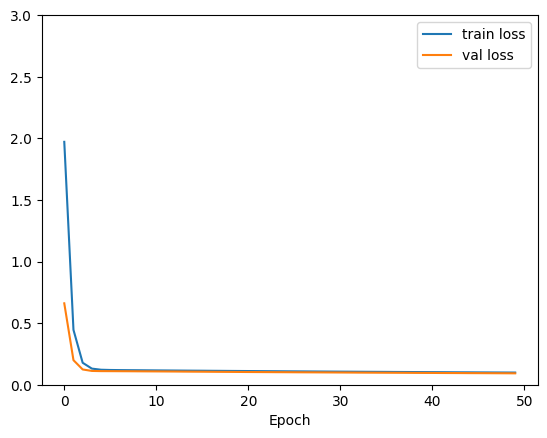

In [37]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
# plt.plot(H.history['r2_score'], label='train r2')
# plt.plot(H.history['val_r2_score'], label='val r2')
plt.legend()
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim([0, 3])
plt.plot()

In [38]:
pred = Yscaler.inverse_transform(predictions2D_test)
np.exp(pred)

array([[  63.72083  ],
       [ 335.43265  ],
       [  93.471115 ],
       [ 256.45535  ],
       [ 244.40144  ],
       [  19.20978  ],
       [  30.383121 ],
       [ 146.01158  ],
       [ 101.811165 ],
       [  24.923656 ],
       [ 279.63864  ],
       [ 646.4927   ],
       [  19.876549 ],
       [ 132.55211  ],
       [  62.455738 ],
       [ 214.83856  ],
       [  22.104624 ],
       [ 241.01186  ],
       [  48.89986  ],
       [ 174.8501   ],
       [   9.056951 ],
       [  85.31132  ],
       [ 294.52722  ],
       [  85.70666  ],
       [ 203.2758   ],
       [  16.684517 ],
       [  56.38285  ],
       [  12.720836 ],
       [  64.27853  ],
       [   9.248176 ],
       [  65.50669  ],
       [ 107.62815  ],
       [ 150.79721  ],
       [ 146.32146  ],
       [2412.1768   ],
       [  46.661926 ],
       [  54.15843  ],
       [ 141.13664  ],
       [ 223.30324  ],
       [ 116.71272  ],
       [  45.792023 ],
       [  30.286274 ],
       [ 129.40074  ],
       [ 19

## 3.3. Modelo combinado con Late Fusion de modelo 1D - MLP y 2D - CNN VGG16 con Fine-Tuning para regresión

Configuramos un modelo combinado conformado por las dos arquitecturas anteriores, que recibe dos inputs y calcula un output (regresión). Usamos una estrategia de Late Fusion, añadiendo capas densas al final tras combinar las salidas de cada rama

In [46]:
model1D = Sequential()
model1D.add(Dense(124, input_shape=(XtrainScaled.shape[-1],), activation="relu"))
model1D.add(Dense(32, activation="relu"))
model1D.add(Dense(1, activation="linear"))
model1D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 124)               2108      
                                                                 
 dense_23 (Dense)            (None, 32)                4000      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6141 (23.99 KB)
Trainable params: 6141 (23.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')

last = base_model.layers[-1].output
x = GlobalMaxPooling2D()(last)
x = Dense(1024, activation='relu', kernel_constraint=max_norm(3.))(x)
x = Dense(1, activation='linear', name='predictions')(x)

model2D = Model(base_model.input, x)

model2D.summary()

Capa input_4 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 

In [48]:
combined = Concatenate()([model1D.output, model2D.output])

z = Dense(2, activation="relu")(combined) ## CODE
z = Dense(1, activation="linear")(z) ## CODE

modelCombined = Model(inputs=[model1D.input, model2D.input], outputs=z)

modelCombined.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

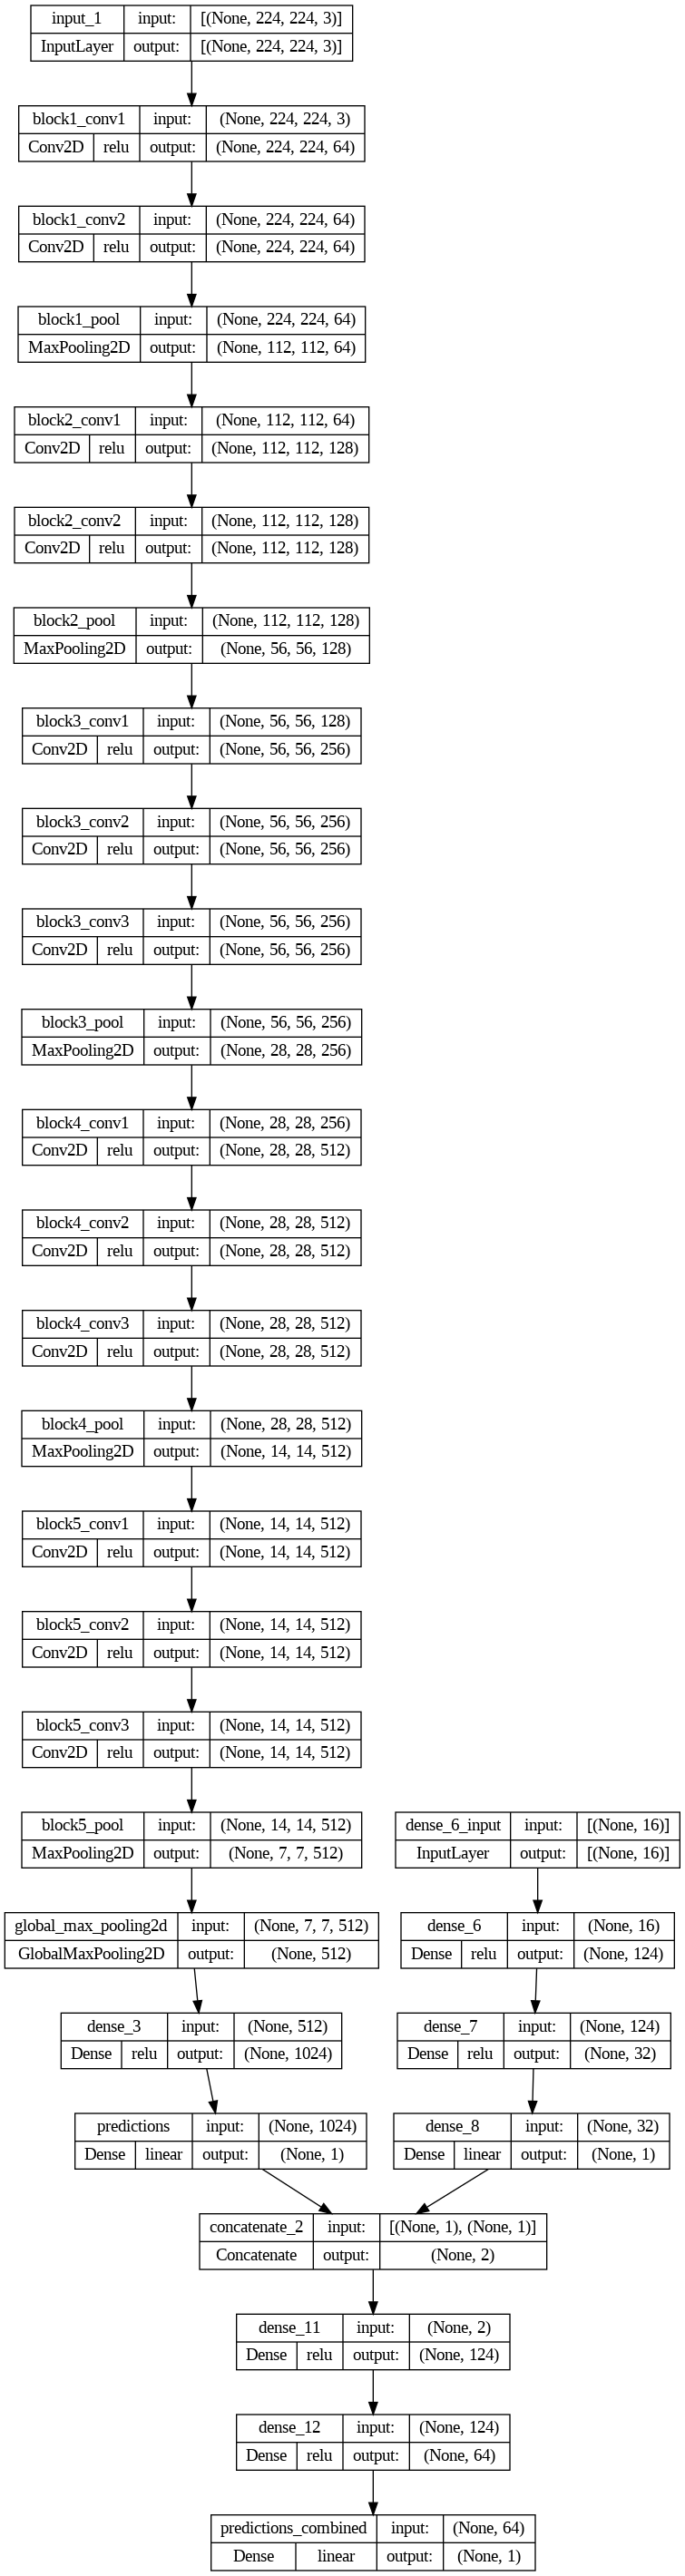

In [31]:
plot_model(modelCombined, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [49]:
n_epochs = 50
batch_size = 256
lr = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=lr,
      decay_steps=100,
      decay_rate=0.5,
      staircase=True)

earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
)

modelCombined.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=lr), metrics=["mse", "mae","R2Score"])
H = modelCombined.fit(x=[XtrainScaled,train_x_imgs], y=YtrainScaled, validation_data=([XvalScaled,val_x_imgs], YvalScaled), epochs=n_epochs, batch_size=batch_size, callbacks=[earlyStopping_callback])

predictionsCombined_train = modelCombined.predict([XtrainScaled,train_x_imgs], batch_size=batch_size)
predictionsCombined_val = modelCombined.predict([XvalScaled,val_x_imgs], batch_size=batch_size)
predictionsCombined_test = modelCombined.predict([XtestScaled,test_x_imgs], batch_size=batch_size)
#print(predictionsCombined_test)
eval_test = modelCombined.evaluate([XtestScaled,test_x_imgs], YtestScaled)
print(eval_test)

Epoch 1/50
6/6 [==============================] - 13s 2s/step - loss: 0.2934 - mse: 0.2934 - mae: 0.5114 - r2_score: -11.3096 - val_loss: 0.2798 - val_mse: 0.2798 - val_mae: 0.4984 - val_r2_score: -10.1802
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.2568 - mse: 0.2568 - mae: 0.4771 - r2_score: -9.7738 - val_loss: 0.2547 - val_mse: 0.2547 - val_mae: 0.4746 - val_r2_score: -9.1777
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 0.2364 - mse: 0.2364 - mae: 0.4573 - r2_score: -8.9180 - val_loss: 0.2407 - val_mse: 0.2407 - val_mae: 0.4609 - val_r2_score: -8.6175
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 0.2246 - mse: 0.2246 - mae: 0.4454 - r2_score: -8.4242 - val_loss: 0.2323 - val_mse: 0.2323 - val_mae: 0.4525 - val_r2_score: -8.2811
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 0.2173 - mse: 0.2173 - mae: 0.4378 - r2_score: -8.1173 - val_loss: 0.2269 - val_mse: 0.2269 - val_mae: 0.4472 - 

[]

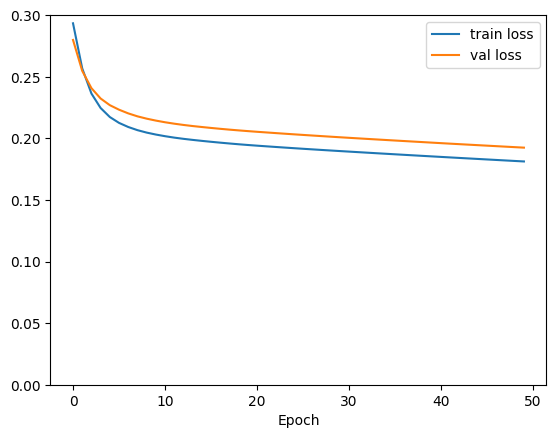

In [50]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
# plt.plot(H.history['r2_score'], label='train r2')
# plt.plot(H.history['val_r2_score'], label='val r2')
plt.legend()
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim([0, 0.3])
plt.plot()

In [51]:
pred = Yscaler.inverse_transform(predictionsCombined_test)
np.exp(pred)

array([[20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],
       [20.096262],


Como conclusión a este intento de arquitectura vemos que la red no termina de aprender, ya que ofrece siempre los mismo valores como output. Hemos probado con distintos learning rates y con todos obtenemos el mismo resultado

## 3.4. Modelo combinado con Early Fusion de modelo 1D - MLP y embeddings de modelo 2D - CNN VGG16 con Fine-Tuning para regresión

Configuramos un modelo combinado conformado por las dos arquitecturas anteriores, que recibe dos inputs y calcula un output (regresión). Usamos una estrategia de Early Fusion, combinando los embeddings de salida de la capa CNN con el input de datos tabulares de la red MLP

In [27]:
InputLayer = Sequential()
InputLayer.add(Input(shape=(XtrainScaled.shape[-1],)))
InputLayer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')

last = base_model.layers[-1].output
x = GlobalMaxPooling2D(name='embeddings')(last)

model2D = Model(base_model.input, x)

model2D.summary()

Capa input_4 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 

In [29]:
combined = Concatenate()([InputLayer.output, model2D.output])

z = Dense(124, activation="relu")(combined) ## CODE
z = Dense(32, activation="relu")(combined) ## CODE
z = Dense(1, activation="linear")(z) ## CODE

modelCombined = Model(inputs=[InputLayer.input, model2D.input], outputs=z)

modelCombined.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

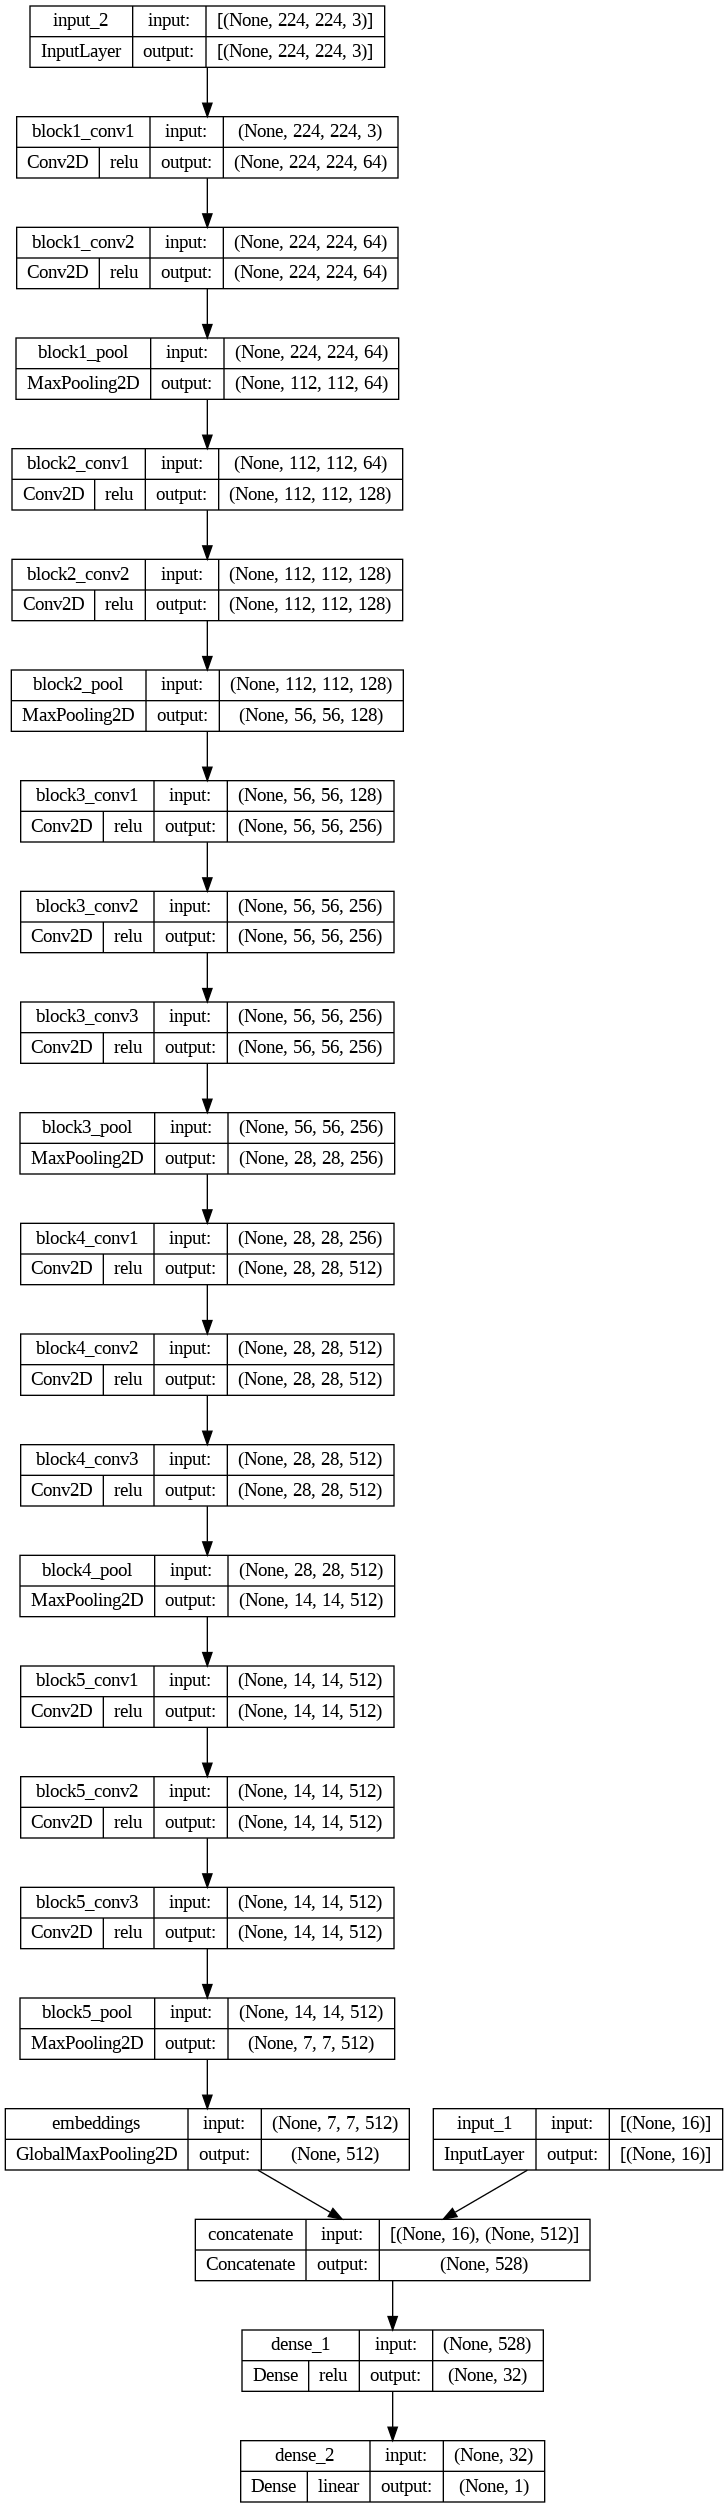

In [21]:
plot_model(modelCombined, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [30]:
n_epochs = 25
batch_size = 256
lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=lr,
      decay_steps=100,
      decay_rate=0.95,
      staircase=True)

earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
)

modelCombined.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=lr_schedule), metrics=["mse", "mae","R2Score"])
H = modelCombined.fit(x=[XtrainScaled,train_x_imgs], y=YtrainScaled, validation_data=([XvalScaled,val_x_imgs], YvalScaled), epochs=n_epochs, batch_size=batch_size, callbacks=[earlyStopping_callback])

predictionsCombined_train = modelCombined.predict([XtrainScaled,train_x_imgs], batch_size=batch_size)
predictionsCombined_val = modelCombined.predict([XvalScaled,val_x_imgs], batch_size=batch_size)
predictionsCombined_test = modelCombined.predict([XtestScaled,test_x_imgs], batch_size=batch_size)
#print(predictionsCombined_test)
eval_test = modelCombined.evaluate([XtestScaled,test_x_imgs], YtestScaled)
print(eval_test)

Epoch 1/25
6/6 [==============================] - 12s 2s/step - loss: 0.6727 - mse: 0.6727 - mae: 0.6518 - r2_score: -27.2282 - val_loss: 0.5701 - val_mse: 0.5701 - val_mae: 0.6015 - val_r2_score: -21.7761
Epoch 2/25
6/6 [==============================] - 11s 2s/step - loss: 0.5729 - mse: 0.5729 - mae: 0.5992 - r2_score: -23.0386 - val_loss: 0.4987 - val_mse: 0.4987 - val_mae: 0.5562 - val_r2_score: -18.9244
Epoch 3/25
6/6 [==============================] - 11s 2s/step - loss: 0.5001 - mse: 0.5001 - mae: 0.5627 - r2_score: -19.9838 - val_loss: 0.4427 - val_mse: 0.4427 - val_mae: 0.5246 - val_r2_score: -16.6875
Epoch 4/25
6/6 [==============================] - 11s 2s/step - loss: 0.4446 - mse: 0.4446 - mae: 0.5291 - r2_score: -17.6568 - val_loss: 0.4017 - val_mse: 0.4017 - val_mae: 0.4995 - val_r2_score: -15.0476
Epoch 5/25
6/6 [==============================] - 11s 2s/step - loss: 0.4025 - mse: 0.4025 - mae: 0.5053 - r2_score: -15.8881 - val_loss: 0.3652 - val_mse: 0.3652 - val_mae: 0.

[]

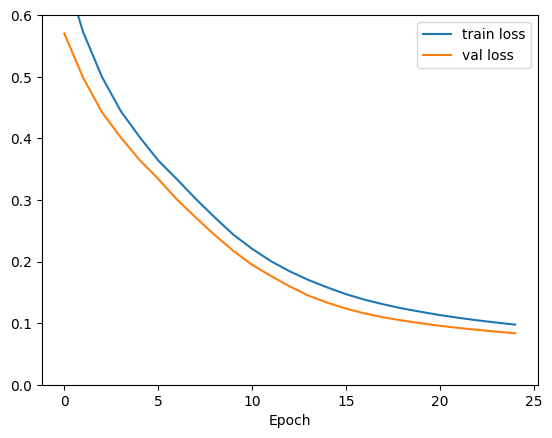

In [31]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
# plt.plot(H.history['r2_score'], label='train r2')
# plt.plot(H.history['val_r2_score'], label='val r2')
plt.legend()
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim([0, 0.6])
plt.plot()

In [32]:
pred = Yscaler.inverse_transform(predictionsCombined_test)
np.exp(pred)

array([[2.05623917e+02],
       [3.01764282e+02],
       [1.36297278e+03],
       [6.06077698e+02],
       [1.49788742e+02],
       [2.22982666e+02],
       [9.12392273e+01],
       [2.15522339e+02],
       [9.01533508e+02],
       [1.14576622e+02],
       [6.82134323e+01],
       [2.82371277e+02],
       [2.45453613e+02],
       [2.49792309e+01],
       [7.10037079e+01],
       [6.04529419e+01],
       [2.53020000e+01],
       [6.70451736e+01],
       [9.36845398e+01],
       [7.62302551e+01],
       [3.46494019e+02],
       [7.74833679e+02],
       [2.75879486e+02],
       [1.42163101e+02],
       [4.99955017e+02],
       [1.21293526e+02],
       [1.25616550e+01],
       [3.74719757e+02],
       [5.09922180e+02],
       [5.07257652e+01],
       [1.23259048e+02],
       [2.52720886e+02],
       [1.57472427e+02],
       [1.47001495e+02],
       [1.64157753e+01],
       [2.54323013e+02],
       [8.53499374e+01],
       [7.61615784e+02],
       [1.18074936e+02],
       [1.23243629e+02],


In [35]:
np.exp(pred) - np.exp(y_test)

array([[ -41.37608337,   80.62391663,  -44.37608337, ...,   85.62391663,
         165.62391663,  115.62391663],
       [  54.76428223,  176.76428223,   51.76428223, ...,  181.76428223,
         261.76428223,  211.76428223],
       [1115.97277832, 1237.97277832, 1112.97277832, ..., 1242.97277832,
        1322.97277832, 1272.97277832],
       ...,
       [-212.60821533,  -90.60821533, -215.60821533, ...,  -85.60821533,
          -5.60821533,  -55.60821533],
       [-155.63129425,  -33.63129425, -158.63129425, ...,  -28.63129425,
          51.36870575,    1.36870575],
       [ -55.68788147,   66.31211853,  -58.68788147, ...,   71.31211853,
         151.31211853,  101.31211853]])

# 4. Optimización de hiper-parámetros

---



Realizamos una optimización de hiper-parámetros únicamente para la red MLP por motivos de tiempo y capacidad disponible para hacerlo con la red combinada.

Como parámetros de estudio tenemos el learning rate, el decay rate utilizado en ExponentialDecay y la cantidad de neuronas de la primera capa densa de la rama MLP final

In [17]:
space = {
    'lr': hp.choice('lr', [0.01, 0.001, 0.0001]),
    'decay_rate_lr': hp.choice('decay_rate_lr', [0.95, 0.5]),
    'neurons_dense': hp.choice('neurons_dense', [124, 256]),
}

In [19]:
def create_net(pars):
  print ('Parameters: ', pars)

  n_epochs = 50
  batch_size = 256
  lr = pars['lr']

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=100,
        decay_rate=pars['decay_rate_lr'],
        staircase=True)

  model1D = Sequential()
  model1D.add(Dense(pars['neurons_dense'], input_shape=(XtrainScaled.shape[-1],), activation="relu"))
  model1D.add(Dense(32, activation="relu"))
  model1D.add(Dense(1, activation="linear"))
  model1D.summary()

  model1D.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=lr_schedule), metrics=["mse", "mae","R2Score"])
  H = model1D.fit(XtrainScaled, YtrainScaled, validation_data=(XvalScaled, YvalScaled), epochs=n_epochs, batch_size=batch_size)

  best_epoch_loss = np.argmin(H.history['val_loss'])
  best_val_loss = np.min(H.history['val_loss'])
  best_val_r2 = np.max(H.history['val_r2_score'])

  print('Epoch {} - val r2: {} - val loss: {}'.format(best_epoch_loss, best_val_r2, best_val_loss))
  sys.stdout.flush()

  return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 'eval_time': time.time(), 'status': STATUS_OK, 'model': model1D, 'history': H}

In [20]:
trials = Trials()
best = fmin(create_net, space, algo=tpe.suggest, max_evals=10, trials=trials)
print(best)

Parameters: 
{'decay_rate_lr': 0.5, 'lr': 0.001, 'neurons_dense': 124}
Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense_3 (Dense)             (None, 124)               2108      

 dense_4 (Dense)             (None, 32)                4000      

 dense_5 (Dense)             (None, 1)                 33        


Total params: 6141 (23.99 KB)

Trainable params: 6141 (23.99 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________

Epoch 1/50

6/6 [==============================] - 1s 59ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1220 - r2_score: 0.0141 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.1135 - val_r2_score: 0.1864

Epoch 2/50

6/6 [==============================] - 0s 15ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1196 - r2_score: 0.0439 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1118 - val_r2_scor

In [21]:
trials.results

[{'loss': 0.017664460465312004,
  'best_epoch': 49,
  'eval_time': 1718533065.8542874,
  'status': 'ok',
  'model': <keras.src.engine.sequential.Sequential at 0x79dd51e31030>,
  'history': <keras.src.callbacks.History at 0x79dcfc58cac0>},
 {'loss': 0.06029007211327553,
  'best_epoch': 49,
  'eval_time': 1718533073.819911,
  'status': 'ok',
  'model': <keras.src.engine.sequential.Sequential at 0x79dcfc5be320>,
  'history': <keras.src.callbacks.History at 0x79dcfc2e4370>},
 {'loss': 0.020126136019825935,
  'best_epoch': 49,
  'eval_time': 1718533085.236994,
  'status': 'ok',
  'model': <keras.src.engine.sequential.Sequential at 0x79dcfc2f1ea0>,
  'history': <keras.src.callbacks.History at 0x79dcfc53d720>},
 {'loss': 0.028043676167726517,
  'best_epoch': 49,
  'eval_time': 1718533096.6533656,
  'status': 'ok',
  'model': <keras.src.engine.sequential.Sequential at 0x79dcfc1ebdc0>,
  'history': <keras.src.callbacks.History at 0x79dcfd791390>},
 {'loss': 0.022724974900484085,
  'best_epoch':

In [30]:
trials.trials[5]

{'state': 2,
 'tid': 5,
 'spec': None,
 'result': {'loss': 0.014189443551003933,
  'best_epoch': 49,
  'eval_time': 1718533119.651919,
  'status': 'ok',
  'model': <keras.src.engine.sequential.Sequential at 0x79dcfd7f4220>,
  'history': <keras.src.callbacks.History at 0x79dcfd47f130>},
 'misc': {'tid': 5,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'decay_rate_lr': [5], 'lr': [5], 'neurons_dense': [5]},
  'vals': {'decay_rate_lr': [0], 'lr': [1], 'neurons_dense': [1]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 6, 16, 10, 18, 28, 113000),
 'refresh_time': datetime.datetime(2024, 6, 16, 10, 18, 39, 651000)}

In [31]:
def unpack_values(trial):
    vals = trial["misc"]["vals"]
    # unpack the one-element lists to values
    # and skip over the 0-element lists
    rval = {}
    for k, v in list(vals.items()):
        if v:
            rval[k] = v[0]
    return rval

vals = unpack_values(trials.trials[5])
best_values = space_eval(space, vals)
best_values

{'decay_rate_lr': 0.95, 'lr': 0.001, 'neurons_dense': 256}

# 5. Conclusiones

Como conclusiones finales podemos decir que para este experimento hemos obtenido mejores resultados con la estrategia Early Fusion que con la Late Fusion, ya que hemos conseguido que la red aprenda aunque los resultados no sean muy precisos.

También concluimos que para este problema de regresión obtenemos mejores resultados únicamente con la red MLP que con la CNN o la combinada. Para lograr unos resultados mejores con estas dos últimas arquitecturas deberíamos probar con un mayor número de imágenes o con alguna técnica de data augmentation.

En cuanto a los hiper-parámetros tras varias intentos manuales y un estudio de optimización vemos que para este experimento obtenemos los mejores resultados con lr=0.001, un decay_rate=0.95 y 256 neuronas en la primera capa densa de la red combinada. El mayor tamaño de batch con el que conseguimos que la GPU entrenara la red combinada fue de 256

Por motivos de tiempo y capacidad los entrenos no han superado las 50 epochs y es posible que con un entrenamiento más largo la red fuese capaz de aprender más y ofrecer mejores resultados